<h1>The Titanic Dataset : can we predict how survive ?

<h2>1. Imports & first explorations

Let's start with the imports we will need for this work !

In [83]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import model_selection
from sklearn import preprocessing
from sklearn import metrics
from sklearn import impute

from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.experimental import enable_iterative_imputer

print('Setup completed')

Setup completed


Then we will make the next ligns to import our data, we will repeat these lines of code to reimport our data everytime we want to test new things on our data.

In [84]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
index_test = test.PassengerId
X_train = train.drop(columns=['Survived'], axis=1)
y_train = train.Survived
print('Data is ready')

Data is ready


In [85]:
X_train.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


<h2>2. First model without feature engineering.
<h4>We are only going to consider 'main' features and erase the others, and we wille have our first model.

In [86]:
X_train = X_train.drop(columns=['Cabin', 'Name', 'Ticket', 'PassengerId'], axis=1)
X_train = pd.get_dummies(X_train, drop_first=True)
X_train.head(3)


,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
0,3,22.0,1,0,7.2500,True,False,True
1,1,38.0,1,0,71.2833,False,False,False
2,3,26.0,0,0,7.9250,False,False,True


On doit désormais imputer nos données car il nous en manque, notamment dans la colonne 'Age'. Pour cela on va utiliser les imputers de sklearn.

In [87]:
num_cols=['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
imputer=impute.IterativeImputer()
imputer.fit(X_train[num_cols])
imputed=imputer.transform(X_train[num_cols])
X_train.loc[:,num_cols]=imputed
imputed_t=imputer.transform(test[num_cols])
test.loc[:,num_cols]=imputed_t

In [88]:
X_train.head(3)

,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
0,3,22.0,1,0,7.2500,True,False,True
1,1,38.0,1,0,71.2833,False,False,False
2,3,26.0,0,0,7.9250,False,False,True


On peut désormais standardiser nos données, toutefois on ne va pas standardiser nos colonnes factices.

In [89]:
scaler=preprocessing.StandardScaler()
cols= "Pclass,Age,SibSp,Parch,Fare".split(",")

scaler.fit(X_train[cols])
X_train.loc[:,cols] = scaler.transform(X_train[cols]).astype('int64')
test.loc[:,cols] = scaler.transform(test[cols]).astype('int64')

<Axes: >

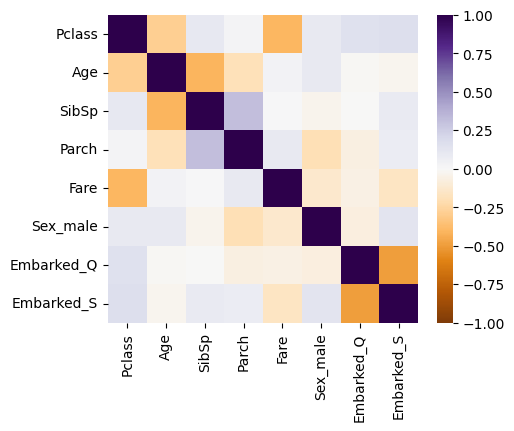

In [90]:
# Calcul de la matrice de corrélation deux à deux
corr_matrix = X_train.corr()

# Initialisation figure
plt.figure(figsize=(5, 4))

# Affichage heatmap
sns.heatmap(corr_matrix, 
            vmin=-1, # borne inf des valeurs à afficher
            vmax=1, # borne sup des valeurs à afficher
            center= 0, # valeur médiane des valeurs à afficher,
            cmap='PuOr', # colormap divergente de violet (PUrple) vers orange (ORange)
           )

In [94]:
for model in [DummyClassifier, LogisticRegression, DecisionTreeClassifier, KNeighborsClassifier, GaussianNB, SVC, RandomForestClassifier, xgboost.XGBClassifier]:
    cls = model()
    kfold = model_selection.KFold(n_splits=10, shuffle=True, random_state=4)
    s=model_selection.cross_val_score(cls, X_train, y_train, scoring="roc_auc", cv=kfold)
    print(
        f"{model.__name__:22} AUC:"
        f"{s.mean():.3f}    STD:  {s.std():.2f}"
    )

DummyClassifier        AUC:0.500    STD:  0.00
LogisticRegression     AUC:0.853    STD:  0.03
DecisionTreeClassifier AUC:0.839    STD:  0.05
KNeighborsClassifier   AUC:0.825    STD:  0.04
GaussianNB             AUC:0.817    STD:  0.03
SVC                    AUC:0.807    STD:  0.04
RandomForestClassifier AUC:0.854    STD:  0.04
XGBClassifier          AUC:0.849    STD:  0.04
